In [1]:
!rm -r ~/.cache/huggingface
!unzip -o /kaggle/input/save-models/modules.zip  -d /
!tree ~/.cache/huggingface -lh

'rm' 不是內部或外部命令、可執行的程式或批次檔。
'unzip' 不是內部或外部命令、可執行的程式或批次檔。


參數太多 - -lh


In [2]:
import transformers
print(transformers.__version__)


E:\ROG_Wei\anaconda3\envs\DMLAB2kaggle\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.40.0


In [3]:
%reset -f
import os
path_input = '/kaggle/input/'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.special import logsumexp
!pip install /kaggle/input/save-models/einops-0.7.0-py3-none-any.whl

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import torch
import tqdm
from transformers import CodeGenTokenizer, AutoModelForCausalLM

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\kaggle\\input\\save-models\\einops-0.7.0-py3-none-any.whl'



Processing c:\kaggle\input\save-models\einops-0.7.0-py3-none-any.whl


In [4]:
import os

# 確認當前工作目錄
print("Current directory:", os.getcwd())

# 列出當前目錄的所有檔案
print("Files in current directory:", os.listdir("./"))


Current directory: C:\Users\ROG_Wei\NLP_TERM
Files in current directory: ['.ipynb_checkpoints', '0.26.0', 'oneClassSVM.joblib', 'phi-2', 'rank-6', 'rank-6.ipynb', 'rank-6.zip', 'tabnet-develop', 'tabnet-develop.zip', 'Tabnet.ipynb', 'train.ipynb', 'train_df.csv', 'zscore.npz']


In [5]:
import torch
import tqdm
device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(device, dtype, flush=True)

cuda:0 torch.float16


In [6]:
!huggingface-cli download microsoft/phi-2 --local-dir /kaggle/input/save-models/models/microsoft/phi-2 --local-dir-use-symlinks False --include all


C:\kaggle\input\save-models\models\microsoft\phi-2


E:\ROG_Wei\anaconda3\envs\DMLAB2kaggle\lib\site-packages\huggingface_hub\commands\download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(

Fetching 0 files: 0it [00:00, ?it/s]
Fetching 0 files: 0it [00:00, ?it/s]


In [7]:
from transformers import CodeGenTokenizer, GPT2LMHeadModel, OPTForCausalLM, BertLMHeadModel, AutoModelForCausalLM
print(device, dtype, flush=True)

dict_llm = {
   #'gpt2' : ('/kaggle/input/save-models/models/gpt2-xl', GPT2LMHeadModel, 1024, dict()),
   #'opt'  : ("/kaggle/input/save-models/models/facebook/opt-2.7b", OPTForCausalLM, 2048, dict()),
   #'bert' : ("/kaggle/input/save-models/models/bert-base-uncased", BertLMHeadModel, 512, {'is_decoder':True}),
   'phi2' : ("./phi-2", AutoModelForCausalLM, 1024,  { 'trust_remote_code':True}),
}

llm_tokenizer = dict()
llm_model = dict()
for _ in dict_llm:
    llm_tokenizer[_] = CodeGenTokenizer.from_pretrained(dict_llm[_][0], add_bos_token = True)
    if llm_tokenizer[_].pad_token is None:
        llm_tokenizer[_].pad_token = llm_tokenizer[_].eos_token
    llm_model[_] = dict_llm[_][1].from_pretrained(dict_llm[_][0], torch_dtype=dtype, device_map=device, **dict_llm[_][3])
    print(_, flush=True)

print('done', flush=True)

cuda:0 torch.float16


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

phi2
done


In [8]:
def compute_entropy(input_ids, logits, attention_mask, token_type_ids=None):
    with torch.no_grad():
        logits = torch.log_softmax(logits.float(), dim=-1)
        # scores S, W ,P
        tokens = input_ids[:, 1:]
        attention_mask = attention_mask[:, 1:]
        
        entD = torch.sum(logits * torch.exp(logits), dim=-1)[:, 1:]
        entL = torch.gather(logits[:, :-1, :], dim=-1, index = tokens[:,:,None])[:,:,0]
        
        entD = -torch.where(attention_mask!=0, entD, np.nan)
        entL = -torch.where(attention_mask!=0, entL, np.nan)
        
    return entD, entL


def generate_logprob(llm_model, llm_tokenizer, prompt, max_length=None, add_special_tokens = True, padding=False):
    with torch.no_grad():
        device = next(llm_model.parameters()).device
        tokens = llm_tokenizer(prompt, return_tensors="pt",
                               max_length=max_length, truncation=max_length is not None, truncation_strategy = 'longest_first', add_special_tokens=add_special_tokens, padding=padding)
        tokens = {_: tokens[_].to(device) for _ in tokens}
        logits = llm_model(**tokens).logits
        return compute_entropy(logits=logits, **tokens)


class Batch:
    def __init__(self, iterable, size=1):
        self.iterable = iterable
        self.size = size
        self.len = len(range(0, len(self.iterable), self.size))
        
    def __iter__(self):
        l = len(self.iterable)
        n = self.size
        for ndx in range(0, l, n):
            yield self.iterable[ndx:min(ndx + n, l)]
    
    def __len__(self):
        return self.len

In [9]:
def feature_extraction(tab):
    for index in tqdm.tqdm(tab.index):
        text = tab.loc[index,'text']    
        tab.loc[index,'len_chr'] = len(text)
    for _ in dict_llm:
        print(_, flush=True)
        for index_list in tqdm.tqdm(Batch(tab.index, batch_size)):
            texts = [tab.loc[index,'text'] for index in index_list]
            vetD, vetL = generate_logprob(llm_model[_], llm_tokenizer[_], texts, max_length=dict_llm[_][2], padding=True)
            vetD = vetD.cpu().numpy()
            vetL = vetL.cpu().numpy()
            
            tab.loc[index_list,'meanchr_'+_] = tab.loc[index_list,'len_chr'].values / np.sum(np.isfinite(vetL),-1)
            
            for op in list_op:
                keyD = 'D'+op+'_'+_
                if keyD in feats_list:
                    op_vet = list_op[op](vetD, axis=-1)
                    for index, value in zip(index_list, op_vet):
                        tab.loc[index, keyD] = value
                        
                keyL = 'L'+op+'_'+_
                if keyL in feats_list:
                    op_vet = list_op[op](vetL, axis=-1)
                    for index, value in zip(index_list, op_vet):
                        tab.loc[index, keyL] = value
    return tab

In [10]:
batch_size = 3
print(batch_size)
#for _ in dict_llm:
#    print(_, flush=True)
#    texts = [' '.join(['hello',]*dict_llm[_][2]) for i in range(batch_size)]
#    vet = generate_logprob(llm_model[_], llm_tokenizer[_], texts, max_length=dict_llm[_][2], padding=True).cpu().numpy()
#print('done', flush=True)

3


In [21]:

tab_train = pd.read_csv('./train_df.csv')
tab_train['label'].value_counts()


class_0 = tab_train[tab_train['label'] == 0].sample(n=8500, random_state=42)
class_1 = tab_train[tab_train['label'] == 1].sample(n=8500, random_state=42)
tab_train_sampled = pd.concat([class_0, class_1]).reset_index(drop=True)


In [22]:
# for SVM


from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score

#feats_list = ['Dmed_phi2', 'Lmed_phi2', 'Dp05_phi2', 'Lstd_phi2', 'meanchr_phi2',]
feats_list = ['len_chr', 'meanchr_phi2', 'Dlen_phi2', 'Dmed_phi2', 'Dmax_phi2','Dmean_phi2', 'Dstd_phi2','Dp05_phi2',  
       'Llen_phi2','Lmed_phi2', 'Lmax_phi2',  'Lmean_phi2',  'Lstd_phi2',  'Lp05_phi2',
       'Dp80_phi2', 'Lp80_phi2', 'Dp90_phi2', 'Lp90_phi2', 'Dp95_phi2',
       'Lp95_phi2', 'Dp98_phi2', 'Lp98_phi2']
#classifier = OneClassSVM(verbose=1,  kernel='rbf', gamma='auto',nu=0.05);

list_op = {
    'len':  lambda a, axis: np.sum(np.isfinite(a),axis),
    'med': np.nanmedian,
    'max': np.nanmax,
    'mean': np.nanmean,
    'std': np.nanstd,
    'p05' : lambda a, axis: np.nanpercentile(a, 5,axis=axis),
    'p80' : lambda a, axis: np.nanpercentile(a,80,axis=axis),
    'p90' : lambda a, axis: np.nanpercentile(a,90,axis=axis),
    'p95' : lambda a, axis: np.nanpercentile(a,95,axis=axis),
    'p98' : lambda a, axis: np.nanpercentile(a,98,axis=axis),
    #'lse': logsumexp,
}

In [23]:
'''
#for oneclasssvm
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score

feats_list = ['Dmed_phi2', 'Lmed_phi2', 'Dp05_phi2', 'Lstd_phi2', ]
classifier = OneClassSVM(verbose=1,  kernel='rbf', gamma='auto',nu=0.05);

list_op = {
    'len':  lambda a, axis: np.sum(np.isfinite(a),axis),
    'med': np.nanmedian,
    'max': np.nanmax,
    'mean': np.nanmean,
    'std': np.nanstd,
    'p05' : lambda a, axis: np.nanpercentile(a, 5,axis=axis),
    'p80' : lambda a, axis: np.nanpercentile(a,80,axis=axis),
    'p90' : lambda a, axis: np.nanpercentile(a,90,axis=axis),
    'p95' : lambda a, axis: np.nanpercentile(a,95,axis=axis),
    'p98' : lambda a, axis: np.nanpercentile(a,98,axis=axis),
    #'lse': logsumexp,
}
'''

"\n#for oneclasssvm\nfrom sklearn.svm import OneClassSVM\nfrom sklearn.metrics import roc_auc_score\n\nfeats_list = ['Dmed_phi2', 'Lmed_phi2', 'Dp05_phi2', 'Lstd_phi2', ]\nclassifier = OneClassSVM(verbose=1,  kernel='rbf', gamma='auto',nu=0.05);\n\nlist_op = {\n    'len':  lambda a, axis: np.sum(np.isfinite(a),axis),\n    'med': np.nanmedian,\n    'max': np.nanmax,\n    'mean': np.nanmean,\n    'std': np.nanstd,\n    'p05' : lambda a, axis: np.nanpercentile(a, 5,axis=axis),\n    'p80' : lambda a, axis: np.nanpercentile(a,80,axis=axis),\n    'p90' : lambda a, axis: np.nanpercentile(a,90,axis=axis),\n    'p95' : lambda a, axis: np.nanpercentile(a,95,axis=axis),\n    'p98' : lambda a, axis: np.nanpercentile(a,98,axis=axis),\n    #'lse': logsumexp,\n}\n"

100%|██████████| 17000/17000 [00:02<00:00, 7556.72it/s]

phi2



100%|██████████| 5667/5667 [59:21<00:00,  1.59it/s]  

Index(['text', 'label', 'len_chr', 'meanchr_phi2', 'Dlen_phi2', 'Llen_phi2',
       'Dmed_phi2', 'Lmed_phi2', 'Dmax_phi2', 'Lmax_phi2', 'Dmean_phi2',
       'Lmean_phi2', 'Dstd_phi2', 'Lstd_phi2', 'Dp05_phi2', 'Lp05_phi2',
       'Dp80_phi2', 'Lp80_phi2', 'Dp90_phi2', 'Lp90_phi2', 'Dp95_phi2',
       'Lp95_phi2', 'Dp98_phi2', 'Lp98_phi2'],
      dtype='object')
done training feature extraction


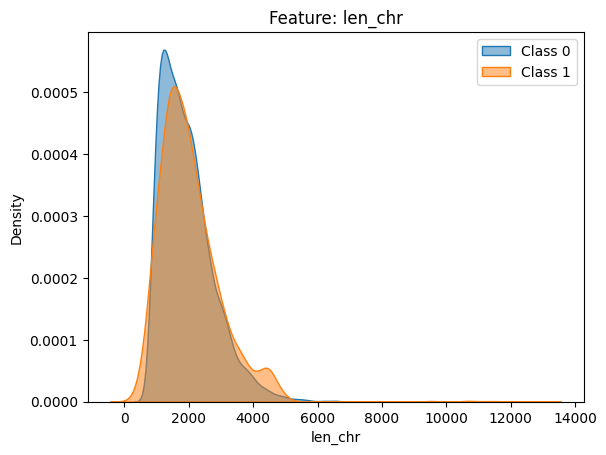

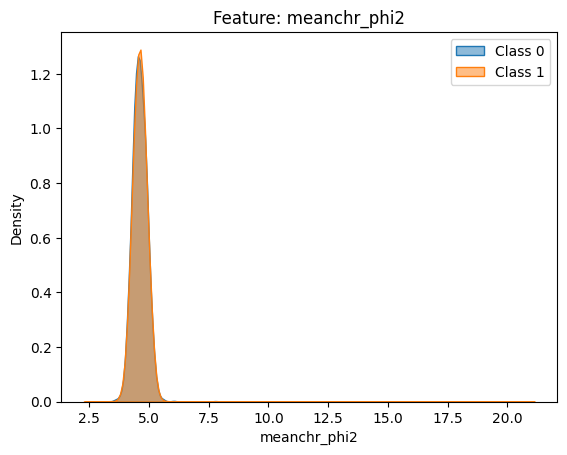

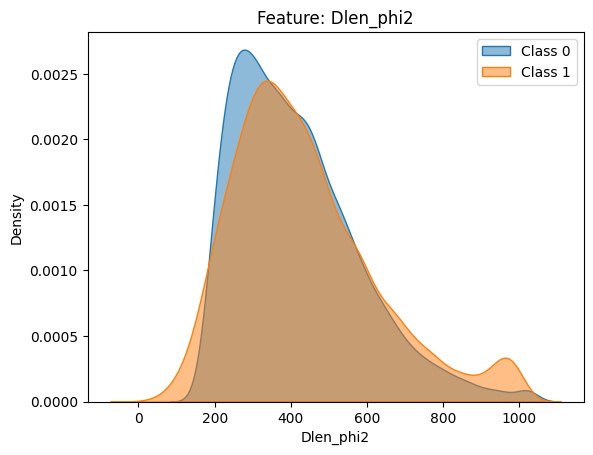

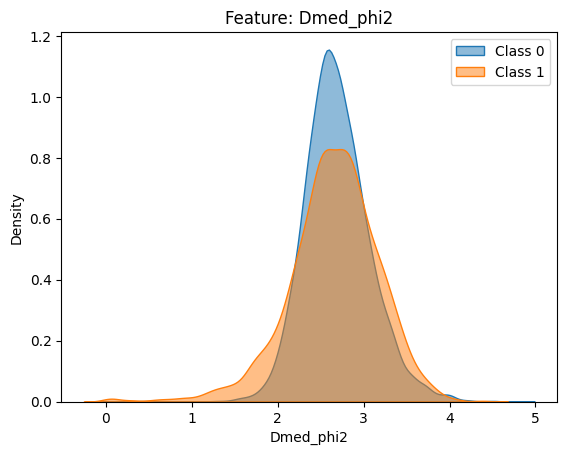

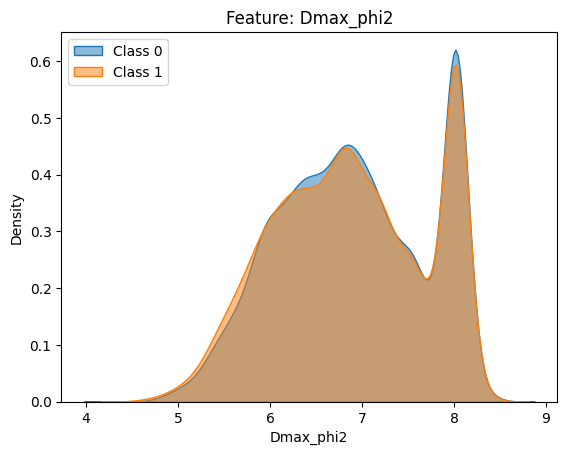

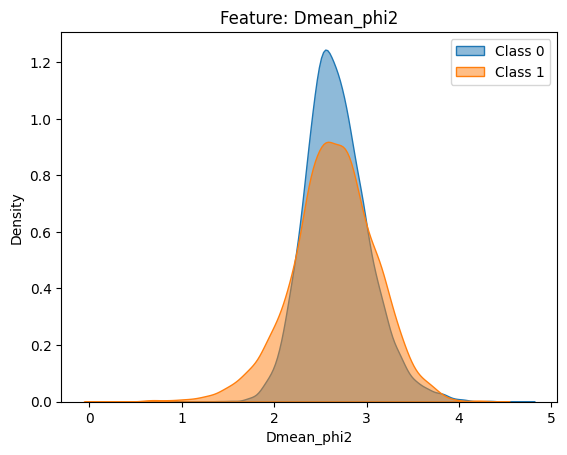

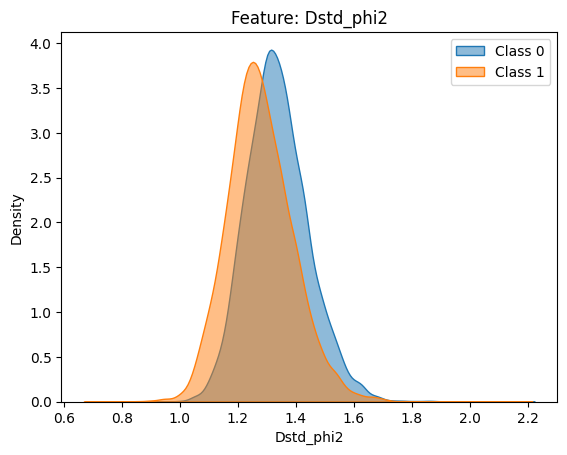

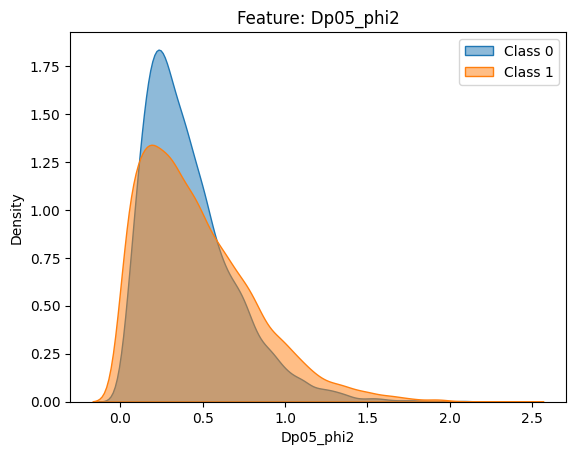

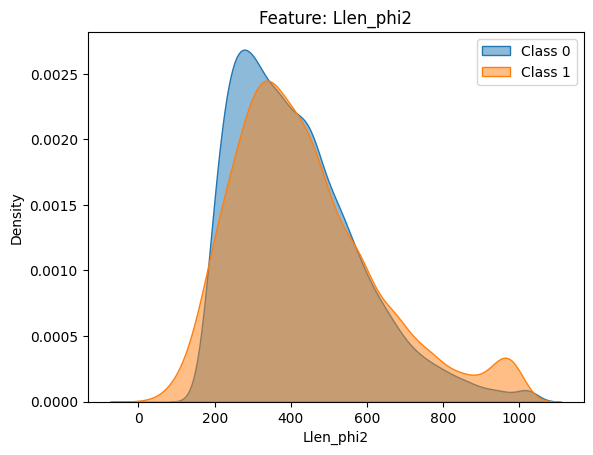

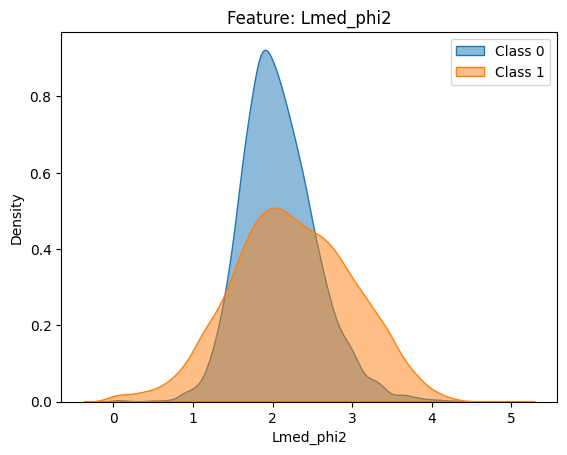

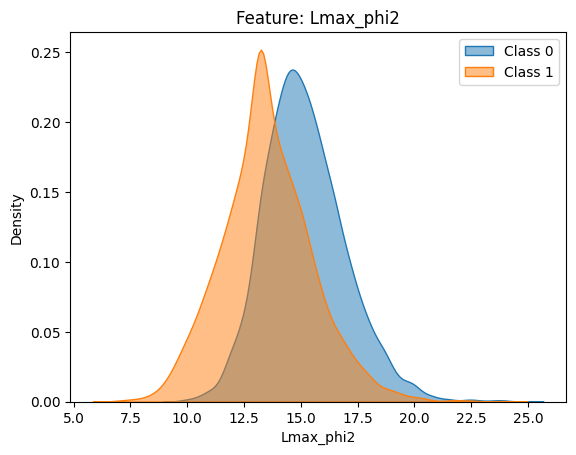

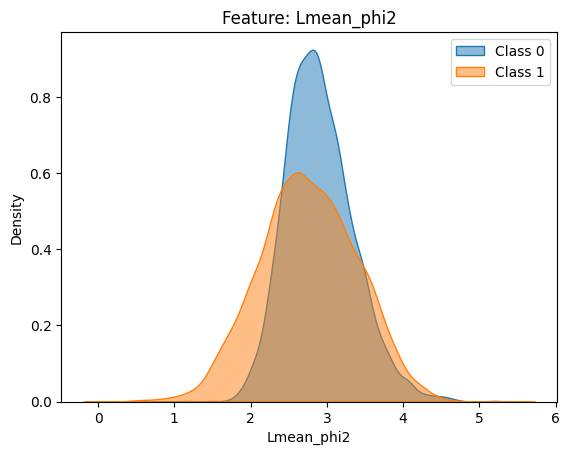

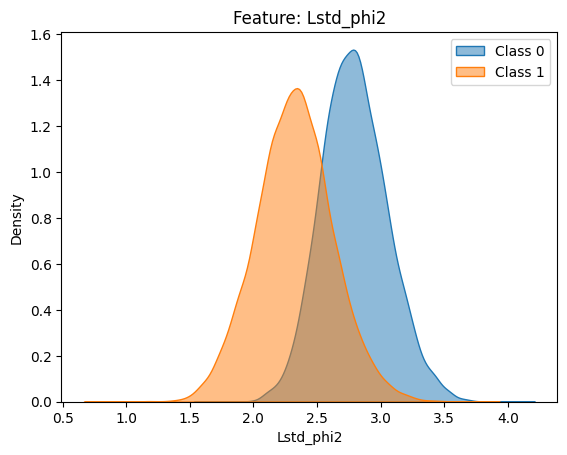

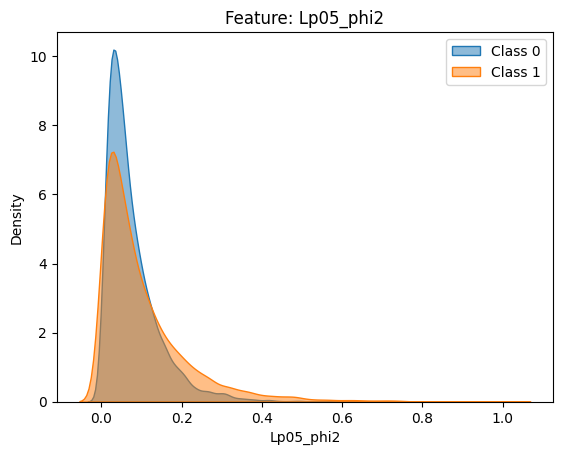

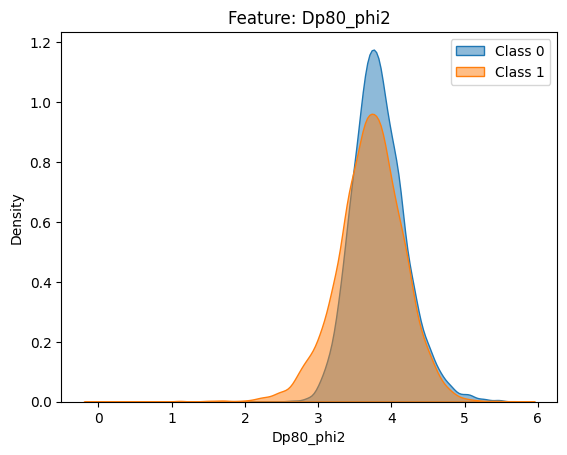

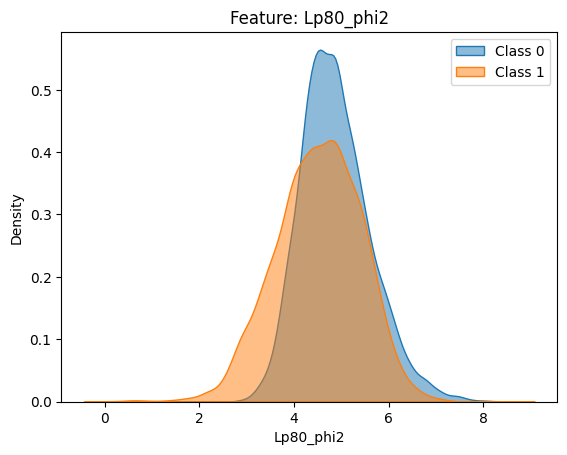

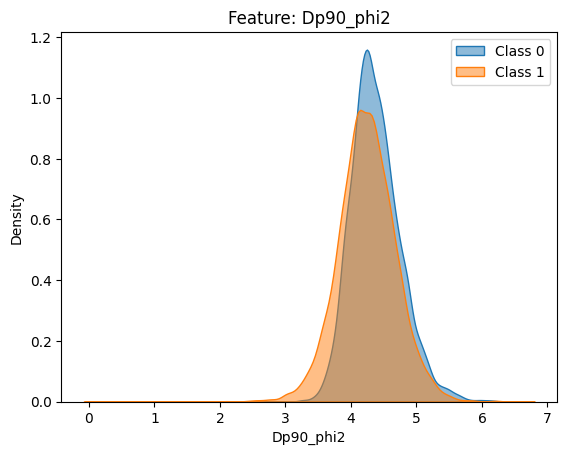

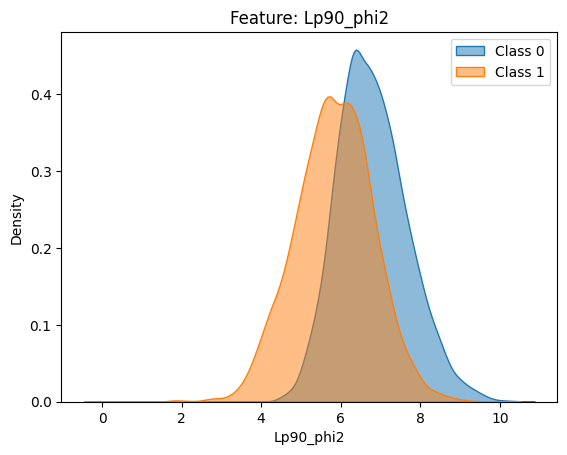

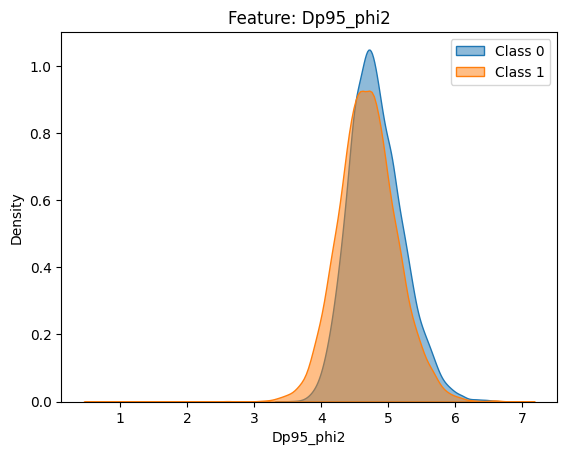

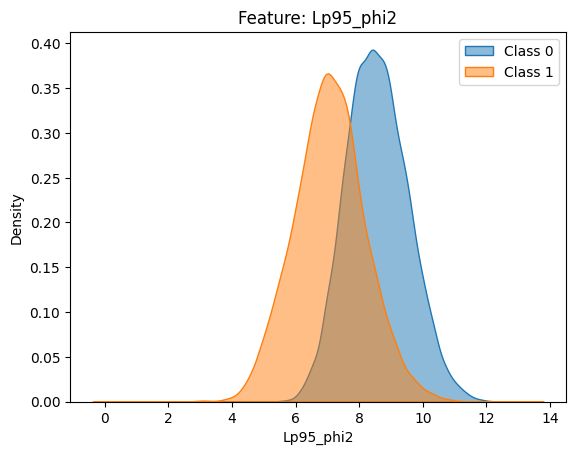

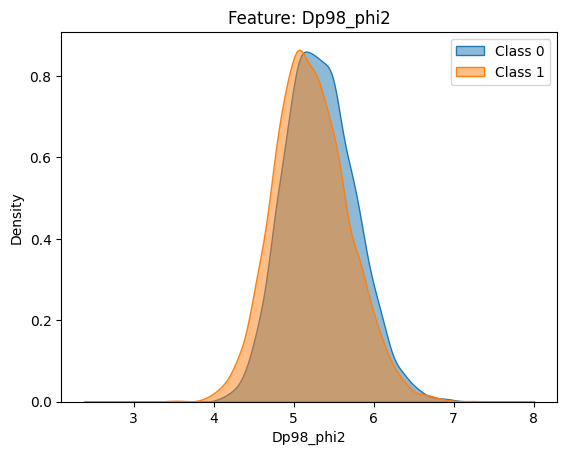

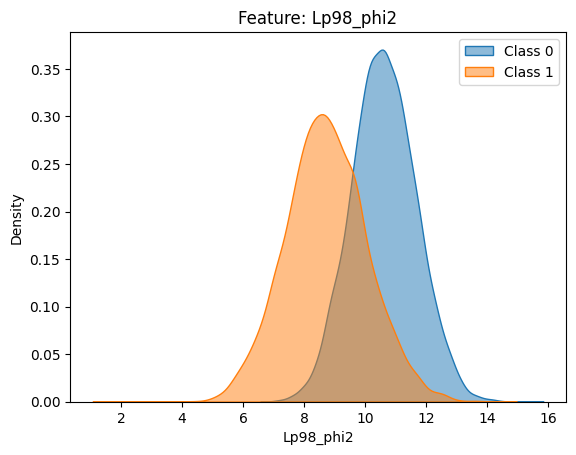

Top features by KS value:
Lstd_phi2: 0.6195294117647059
Lp98_phi2: 0.5830588235294117
Lp95_phi2: 0.5357647058823529
Lp90_phi2: 0.3791764705882353
Lmax_phi2: 0.3708235294117647
Dstd_phi2: 0.2351764705882353
Lmed_phi2: 0.2028235294117647
Lp80_phi2: 0.1932941176470588
Lmean_phi2: 0.184
Dp90_phi2: 0.14176470588235293

Top features by AUC value:
Lmed_phi2: 0.5781577716262976
Lp05_phi2: 0.5392423321799308
len_chr: 0.526011017301038
Dlen_phi2: 0.5250809965397923
Llen_phi2: 0.5250809965397923
Dp05_phi2: 0.5242682006920416
meanchr_phi2: 0.5070465743944637
Dmed_phi2: 0.4967461591695501
Dmax_phi2: 0.49040304498269893
Dmean_phi2: 0.48880905882352943

Top features by p-value:
Lmax_phi2: 0.0
Lstd_phi2: 0.0
Lp90_phi2: 0.0
Lp95_phi2: 0.0
Lp98_phi2: 0.0
Dstd_phi2: 8.986188221679485e-256
Lp80_phi2: 6.188576887090143e-179
Dp90_phi2: 2.7109831185037074e-103
Dp95_phi2: 7.945224962320208e-89
Dp80_phi2: 2.244090461386153e-81
Recommended features: ['Lstd_phi2', 'Lp98_phi2', 'Lp95_phi2', 'Lp90_phi2', 'Lmax_phi

In [24]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp, ttest_ind
import tqdm

# 原始特徵運算
list_op = {
    'len': lambda a, axis: np.sum(np.isfinite(a), axis),
    'med': np.nanmedian,
    'max': np.nanmax,
    'mean': np.nanmean,
    'std': np.nanstd,
    'p05': lambda a, axis: np.nanpercentile(a, 5, axis=axis),
    'p80': lambda a, axis: np.nanpercentile(a, 80, axis=axis),
    'p90': lambda a, axis: np.nanpercentile(a, 90, axis=axis),
    'p95': lambda a, axis: np.nanpercentile(a, 95, axis=axis),
    'p98': lambda a, axis: np.nanpercentile(a, 98, axis=axis),
}

# 假設已經完成 feature_extraction
if True:
    tab_train = feature_extraction(tab_train_sampled)
    print(tab_train_sampled.columns)
    print('done training feature extraction', flush=True)

    '''
    # 自動生成 `phi2` 的所有可能特徵名稱
    feats_list = []
    for op in list_op.keys():
        feats_list.append(f'D{op}_phi2')
        feats_list.append(f'L{op}_phi2')
    feats_list.append('meanchr_phi2')
    '''
    
    # 繪製所有特徵的 01 分布
    for feature in feats_list:
        if feature in tab_train.columns:
            sns.kdeplot(tab_train[tab_train['label'] == 0][feature], label="Class 0", fill=True, alpha=0.5)
            sns.kdeplot(tab_train[tab_train['label'] == 1][feature], label="Class 1", fill=True, alpha=0.5)
            plt.title(f"Feature: {feature}")
            plt.legend()
            plt.show()

    # 計算 KS 值、AUC 值和 p 值
    ks_results = {}
    auc_results = {}
    p_value_results = {}
    
    for feature in feats_list:
        if feature in tab_train.columns:
            class_0 = tab_train[tab_train['label'] == 0][feature].dropna()
            class_1 = tab_train[tab_train['label'] == 1][feature].dropna()
            
            # KS 值
            ks_stat, _ = ks_2samp(class_0, class_1)
            ks_results[feature] = ks_stat
            
            # AUC 值
            try:
                auc = roc_auc_score(tab_train['label'], tab_train[feature].fillna(0))
                auc_results[feature] = auc
            except ValueError:
                auc_results[feature] = 0  # 若 AUC 無法計算
            
            # p 值
            _, p_value = ttest_ind(class_0, class_1, equal_var=False)
            p_value_results[feature] = p_value

    # 排序特徵，按 KS 值降序排列
    sorted_ks_features = sorted(ks_results.items(), key=lambda x: x[1], reverse=True)
    sorted_auc_features = sorted(auc_results.items(), key=lambda x: x[1], reverse=True)
    sorted_p_features = sorted(p_value_results.items(), key=lambda x: x[1])

    print("Top features by KS value:")
    for feature, ks_value in sorted_ks_features[:10]:
        print(f"{feature}: {ks_value}")

    print("\nTop features by AUC value:")
    for feature, auc_value in sorted_auc_features[:10]:
        print(f"{feature}: {auc_value}")

    print("\nTop features by p-value:")
    for feature, p_value in sorted_p_features[:10]:
        print(f"{feature}: {p_value}")

    # 選取前 10 名特徵作為新的 feats_list
    top_features = [feature for feature, _ in sorted_ks_features[:10]]
    print("Recommended features:", top_features)
    
    # 提取最終特徵
    train_feats = tab_train[top_features].values
    train_labels = tab_train['label'].values

    # 標準化
    z_mean = np.mean(train_feats, axis=0, keepdims=True)
    z_std = np.maximum(np.std(train_feats, axis=0, keepdims=True), 1e-4)
    train_feats = (train_feats - z_mean) / z_std

    # 訓練 SVM 模型
    print("Training SVM classifier...", flush=True)
    classifier = SVC(kernel='rbf', C=10.0, gamma=0.1, verbose=True)
    classifier.fit(train_feats, train_labels)
    print("Done training", flush=True)
    
else:
    pass


In [28]:
tab_train

# 將選定特徵與標籤保存到 CSV
selected_features = ['text', 'label','Lstd_phi2', 'Lp98_phi2', 'Lp95_phi2', 'Lmed_phi2', 'Lp05_phi2']
tab_train.to_csv('tab_train.csv', index=False)


In [30]:
df_check = pd.read_csv('tab_train.csv')
print(df_check.tail())


                                                    text  label  len_chr  \
16995  Have you ever thought that there could be life...      1   2194.0   
16996  Have you ever wondered if you are making your ...      1   3243.0   
16997  Exploring venus is a very hard idea to even st...      1   2057.0   
16998  Are google's self driven cars a good idea toda...      1   1695.0   
16999  Should we use this new technology?\n\nI would ...      1   1116.0   

       meanchr_phi2  Dlen_phi2  Llen_phi2  Dmed_phi2  Lmed_phi2  Dmax_phi2  \
16995      4.638478      473.0      473.0   3.087433   3.089780   6.541145   
16996      4.619658      702.0      702.0   2.367169   1.651420   7.011376   
16997      4.874408      422.0      422.0   1.981692   1.108539   5.811642   
16998      4.532086      374.0      374.0   3.040275   2.848246   6.363591   
16999      4.982143      224.0      224.0   2.384345   1.902394   6.930153   

       Lmax_phi2  ...  Dp05_phi2  Lp05_phi2  Dp80_phi2  Lp80_phi2  Dp90_ph

In [16]:
'''
import seaborn as sns
import matplotlib.pyplot as plt

if True:
    tab_train = feature_extraction(tab_train_sampled)
    print(tab_train_sampled.columns)
    print('done training feature extraction', flush=True)

    for feature in feats_list:
        sns.kdeplot(tab_train[tab_train['label'] == 0][feature], label="Class 0", fill=True, alpha=0.5)
        sns.kdeplot(tab_train[tab_train['label'] == 1][feature], label="Class 1", fill=True, alpha=0.5)
        plt.title(f"Feature: {feature}")
        plt.legend()
        plt.show()
    
    # 提取特徵
    train_feats = tab_train[feats_list].values
    train_labels = tab_train['label'].values
    
    # 標準化
    z_mean = np.mean(train_feats, axis=0, keepdims=True)
    z_std = np.maximum(np.std(train_feats, axis=0, keepdims=True), 1e-4)
    train_feats = (train_feats - z_mean) / z_std
    
    # 印出 z_mean 和 z_std
    print("z_mean:", z_mean)
    print("z_std:", z_std)
    
    # 訓練 SVM 模型
    print("Training SVM classifier...", flush=True)
    #classifier = SVC(kernel='rbf', C=1.0, gamma='scale', verbose=True)
    classifier = SVC(kernel='rbf', C=10.0, gamma= 0.1 , verbose=True)
    classifier.fit(train_feats, train_labels)
    print("Done training", flush=True)


    
else:
    pass

#print(z_mean, z_std)
'''

'\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\nif True:\n    tab_train = feature_extraction(tab_train_sampled)\n    print(tab_train_sampled.columns)\n    print(\'done training feature extraction\', flush=True)\n\n    for feature in feats_list:\n        sns.kdeplot(tab_train[tab_train[\'label\'] == 0][feature], label="Class 0", fill=True, alpha=0.5)\n        sns.kdeplot(tab_train[tab_train[\'label\'] == 1][feature], label="Class 1", fill=True, alpha=0.5)\n        plt.title(f"Feature: {feature}")\n        plt.legend()\n        plt.show()\n    \n    # 提取特徵\n    train_feats = tab_train[feats_list].values\n    train_labels = tab_train[\'label\'].values\n    \n    # 標準化\n    z_mean = np.mean(train_feats, axis=0, keepdims=True)\n    z_std = np.maximum(np.std(train_feats, axis=0, keepdims=True), 1e-4)\n    train_feats = (train_feats - z_mean) / z_std\n    \n    # 印出 z_mean 和 z_std\n    print("z_mean:", z_mean)\n    print("z_std:", z_std)\n    \n    # 訓練 SVM 模型\n    print("Trainin

In [17]:
'''
if True:
    tab_train = feature_extraction(tab_train)
    print(tab_train.columns)
    print('done training feature extraction', flush=True)

    train_feats = tab_train[tab_train['label']==0][feats_list].values
    z_mean = np.mean(train_feats, 0, keepdims=True)
    z_std  = np.maximum(np.std(train_feats, 0, keepdims=True), 1e-4)

    classifier.fit((train_feats - z_mean)/z_std)
    
    print('done training', flush=True)
    
else:
    pass

print(z_mean, z_std)
'''

"\nif True:\n    tab_train = feature_extraction(tab_train)\n    print(tab_train.columns)\n    print('done training feature extraction', flush=True)\n\n    train_feats = tab_train[tab_train['label']==0][feats_list].values\n    z_mean = np.mean(train_feats, 0, keepdims=True)\n    z_std  = np.maximum(np.std(train_feats, 0, keepdims=True), 1e-4)\n\n    classifier.fit((train_feats - z_mean)/z_std)\n    \n    print('done training', flush=True)\n    \nelse:\n    pass\n\nprint(z_mean, z_std)\n"

In [18]:
'''
import seaborn as sns
import matplotlib.pyplot as plt
for feat in feats_list:
    sns.boxplot(data=tab_train, x='label', y=feat)
    plt.title(feat)
    plt.show()
'''

"\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nfor feat in feats_list:\n    sns.boxplot(data=tab_train, x='label', y=feat)\n    plt.title(feat)\n    plt.show()\n"

In [19]:
'''
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='roc_auc', verbose=3)
grid.fit(train_feats, train_labels)

print("Best parameters:", grid.best_params_)
classifier = grid.best_estimator_

'''

'\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    \'C\': [0.1, 1, 10, 100],\n    \'gamma\': [\'scale\', \'auto\', 0.01, 0.1, 1],\n    \'kernel\': [\'rbf\']\n}\ngrid = GridSearchCV(SVC(), param_grid, cv=5, scoring=\'roc_auc\', verbose=3)\ngrid.fit(train_feats, train_labels)\n\nprint("Best parameters:", grid.best_params_)\nclassifier = grid.best_estimator_\n\n'

In [20]:
#for oneclasssvm
if True:
    tab_train = feature_extraction(tab_train)
    print(tab_train.columns)
    print('done training feature extraction', flush=True)

    train_feats = tab_train[tab_train['generated']==0][feats_list].values
    z_mean = np.mean(train_feats, 0, keepdims=True)
    z_std  = np.maximum(np.std(train_feats, 0, keepdims=True), 1e-4)

    classifier.fit((train_feats - z_mean)/z_std)
    
    print('done training', flush=True)
    
else:
    pass

print(z_mean, z_std)


test_feats = tab_test[feats_list].values
tab_test['generated'] = -1.0*classifier.decision_function((test_feats - z_mean)/z_std)
submission = tab_test[['id','generated']]

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)
pd.read_csv("/kaggle/working/submission.csv")

100%|██████████| 20/20 [00:00<00:00, 3969.81it/s]

phi2



100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

Index(['text', 'label', 'len_chr', 'meanchr_phi2', 'Dlen_phi2', 'Llen_phi2',
       'Dmed_phi2', 'Lmed_phi2', 'Dmax_phi2', 'Lmax_phi2', 'Dmean_phi2',
       'Lmean_phi2', 'Dstd_phi2', 'Lstd_phi2', 'Dp05_phi2', 'Lp05_phi2',
       'Dp80_phi2', 'Lp80_phi2', 'Dp90_phi2', 'Lp90_phi2', 'Dp95_phi2',
       'Lp95_phi2', 'Dp98_phi2', 'Lp98_phi2'],
      dtype='object')
done training feature extraction


KeyError: 'generated'

In [ ]:
'''
# 測試數據
print("Extracting features from test data...", flush=True)

tab_test = pd.read_csv(f'{path_input}/llm-detect-ai-generated-text/test_essays.csv')
tab_test = feature_extraction(tab_test)
test_feats = tab_test[feats_list].values
test_feats = (test_feats - z_mean) / z_std
'''

In [ ]:
'''
# 1. 讀取測試數據
tab_test = pd.read_csv(f'{path_input}/llm-detect-ai-generated-text/test_essays.csv')

# 2. 提取測試數據特徵
print("Extracting features from test data...", flush=True)
tab_test = feature_extraction(tab_test)
print('done test feature extraction', flush=True)

# 3. 獲取測試數據特徵並標準化
test_feats = tab_test[feats_list].values
test_feats = (test_feats - z_mean) / z_std

# 4. 使用 SVC 分類器進行預測，輸出分數
tab_test['generated'] = classifier.decision_function(test_feats)
'''

In [ ]:
'''
submission = tab_test[['id','generated']]

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)
pd.read_csv("/kaggle/working/submission.csv")
'''